# Milestone P4 :

### Through this project we propose new figures and analysis to the "Predicting present with Google Trends paper.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_absolute_error
import statistics

## Q1 : Does the model improve the prediction over the base model for the initial claims data ?

In [3]:
# Load iclaims Data :
data_iclaims = pd.read_csv('merged_iclaims.csv')
# Reshape of the DataFrame into a more convenient form :
data_iclaims.Index = pd.to_datetime(data_iclaims.Index)
# Relevant turning points for analysis :
idx1 = data_iclaims.loc[data_iclaims['Index'].isin(['2009-03-07'])].index.tolist()[0] 
idx2 = data_iclaims.loc[data_iclaims['Index'].isin(['2009-05-02'])].index.tolist()[0]
idx3 = data_iclaims.loc[data_iclaims['Index'].isin(['2009-12-05'])].index.tolist()[0]
idx4 = data_iclaims.loc[data_iclaims['Index'].isin(['2010-02-06'])].index.tolist()[0]
idx5 = data_iclaims.loc[data_iclaims['Index'].isin(['2010-07-10'])].index.tolist()[0]
idx6 = data_iclaims.loc[data_iclaims['Index'].isin(['2010-07-17'])].index.tolist()[0]
idx7 = data_iclaims.loc[data_iclaims['Index'].isin(['2011-01-01'])].index.tolist()[0]
idx8 = data_iclaims.loc[data_iclaims['Index'].isin(['2011-05-07'])].index.tolist()[0]

data_iclaims = data_iclaims.set_index(data_iclaims['Index'])
data_iclaims.index = pd.DatetimeIndex(data_iclaims.index.values,freq='W-SAT') # Indicate that our index is sampled by weeks
data_iclaims.rename(columns = {'claims.sa':'claims_sa'}, inplace = True)
data_iclaims.rename(columns = {'claims.nsa':'claims_nsa'}, inplace = True)
data_iclaims.rename(columns = {'Welfare...Unemployment':'WelfareUnemployment'}, inplace = True)

# Data preprocessing :
data_iclaims['claims_sa']= np.log(data_iclaims['claims_sa'])
data_iclaims['claims_nsa']= np.log(data_iclaims['claims_nsa'])
data_iclaims['s1sa']=data_iclaims['claims_sa'].shift(1,axis=0,fill_value=0) # create seasonnal term for sa claims
data_iclaims.head()

,Index,claims_sa,claims_nsa,Jobs,WelfareUnemployment,s1sa
2004-01-10,2004-01-10,12.777052,13.426751,6.066862,-7.574152,0.000000
2004-01-17,2004-01-17,12.799399,13.103717,-3.558773,-25.237886,12.777052
2004-01-24,2004-01-24,12.774223,12.853862,-6.184409,-17.401619,12.799399
2004-01-31,2004-01-31,12.837344,12.914842,-7.935044,-18.815352,12.774223
2004-02-07,2004-02-07,12.847927,12.979033,-13.310680,-24.104085,12.837344


### Model without rolling window

For this model, we create a model that forecast initial unemployments claims. We use a simple linear regression with seasonal terms for the Baseline model and Google Trends for the Trends model. We first try to replicate the two Anova tables from the paper to make sure that our model is consistent. Then we plot a new figure close to the one that we already replicated (Figure 2), but using the iclaims predictions this time.

### Baseline model :

We only use a seasonnal term $y_{t-1}$ for the linear regression.

In [4]:
mod = smf.ols(formula = 'claims_sa ~ s1sa', data= data_iclaims[1:] )
res = mod.fit()
Predictions = res.predict()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              claims_sa   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     9480.
Date:                Mon, 30 Nov 2020   Prob (F-statistic):          9.22e-275
Time:                        10:20:26   Log-Likelihood:                 669.17
No. Observations:                 390   AIC:                            -1334.
Df Residuals:                     388   BIC:                            -1326.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2549      0.130      1.968      0.0

### Trends model :

We use the seasonnal term $y_{t-1}$ and the Google Trends "Jobs", "Welfare & Unemployment".

In [5]:
# Trends Model :
mod_trends = smf.ols(formula = 'claims_sa ~ s1sa + Jobs + WelfareUnemployment', data= data_iclaims[1:] )
res_trends = mod_trends.fit()
Predictions_trends = res_trends.predict()
print(res_trends.summary())

                            OLS Regression Results                            
Dep. Variable:              claims_sa   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     3261.
Date:                Mon, 30 Nov 2020   Prob (F-statistic):          9.62e-274
Time:                        10:20:26   Log-Likelihood:                 676.05
No. Observations:                 390   AIC:                            -1344.
Df Residuals:                     386   BIC:                            -1328.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.0563    

### MAEs :

According to the tables in the paper, we should start forecasting on the 17th of January 2004 (idx = 1) and end on the 2nd of July 2011 (idx = 391). We evaluate the MAEs at the given turning points in the paper. However, our dataset is constructed such that we cannot predict the exact same dates. Thus, our goal is to approximate the given turning points by close enough time intervals available in our dataset. Some differences in the forecasting improvement between Base and Trend model are expected. 

In [6]:
mae_base_overall = mean_absolute_error(data_iclaims.claims_sa[1:],Predictions)/(data_iclaims.claims_sa[1:].mean())
mae_trends_overall = mean_absolute_error(data_iclaims.claims_sa[1:],Predictions_trends)/(data_iclaims.claims_sa[1:].mean())
improvement_overall = (mae_base_overall-mae_trends_overall)/mae_base_overall*100

mae_base_turningpoint = mean_absolute_error(data_iclaims.claims_sa[idx1:idx2],Predictions[idx1-1:idx2-1])/(data_iclaims.claims_sa[idx1:idx2].mean())
mae_trends_turningpoint = mean_absolute_error(data_iclaims.claims_sa[idx1:idx2],Predictions_trends[idx1-1:idx2-1])/(data_iclaims.claims_sa[idx1:idx2].mean())
improvement_turningpoint = (mae_base_turningpoint-mae_trends_turningpoint)/mae_base_turningpoint*100

mae_base_turningpoint_2 = mean_absolute_error(data_iclaims.claims_sa[idx3:idx4],Predictions[idx3-1:idx4-1])/(data_iclaims.claims_sa[idx3:idx4].mean())
mae_trends_turningpoint_2 = mean_absolute_error(data_iclaims.claims_sa[idx3:idx4],Predictions_trends[idx3-1:idx4-1])/(data_iclaims.claims_sa[idx3:idx4].mean())
improvement_turningpoint_2 = (mae_base_turningpoint_2-mae_trends_turningpoint_2)/mae_base_turningpoint_2*100

mae_base_turningpoint_3 = np.abs(data_iclaims.claims_sa[idx6]-Predictions[idx6-1])/(data_iclaims.claims_sa[idx6])
mae_trends_turningpoint_3 = np.abs(data_iclaims.claims_sa[idx6]-Predictions_trends[idx6-1])/(data_iclaims.claims_sa[idx6])
improvement_turningpoint_3 = (mae_base_turningpoint_3-mae_trends_turningpoint_3)/mae_base_turningpoint_3*100

mae_base_turningpoint_4 = mean_absolute_error(data_iclaims.claims_sa[idx7:idx8],Predictions[idx7-1:idx8-1])/(data_iclaims.claims_sa[idx7:idx8].mean())
mae_trends_turningpoint_4 = mean_absolute_error(data_iclaims.claims_sa[idx7:idx8],Predictions_trends[idx7-1:idx8-1])/(data_iclaims.claims_sa[idx7:idx8].mean())
improvement_turningpoint_4 = (mae_base_turningpoint_4-mae_trends_turningpoint_4)/mae_base_turningpoint_4*100

In [7]:
print('MAE Trends Overall =',mae_trends_overall)
print('MAE Base Overall =',mae_base_overall)
print('MAE Trends Over turningpoint =',mae_trends_turningpoint)
print('MAE Base Over turningpoint =',mae_base_turningpoint)
print('MAE Trends Over turningpoint 2 =',mae_trends_turningpoint_2)
print('MAE Base Over turningpoint 2 =',mae_base_turningpoint_2)
print('MAE Trends Over turningpoint 3 =',mae_trends_turningpoint_3)
print('MAE Base Over turningpoint 3 =',mae_base_turningpoint_3)
print('MAE Trends Over turningpoint 4 =',mae_trends_turningpoint_4)
print('MAE Base Over turningpoint 4 =',mae_base_turningpoint_4)

MAE Trends Overall = 0.0025382631579881727
MAE Base Overall = 0.002551898503544962
MAE Trends Over turningpoint = 0.0022459473763192777
MAE Base Over turningpoint = 0.0022363563719774216
MAE Trends Over turningpoint 2 = 0.002298104150105915
MAE Base Over turningpoint 2 = 0.0027227896803713168
MAE Trends Over turningpoint 3 = 0.0022385778181538136
MAE Base Over turningpoint 3 = 0.004561682535186772
MAE Trends Over turningpoint 4 = 0.003921505688008188
MAE Base Over turningpoint 4 = 0.003968190434459541


### Plots :

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


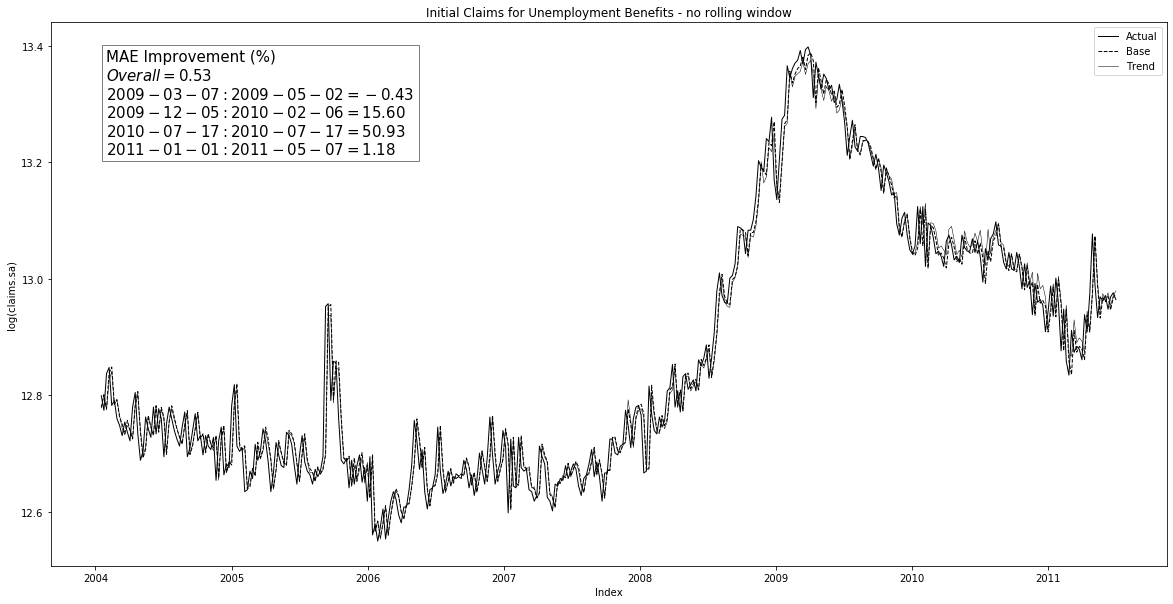

In [8]:
#Plots :
fig,ax = plt.subplots()
ax.plot(data_iclaims['Index'][1:],data_iclaims['claims_sa'][1:],color='black',label='Actual',linewidth=1)
ax.plot(data_iclaims['Index'][1:],Predictions,linestyle='--',color='black',label='Base',linewidth=1)
ax.plot(data_iclaims['Index'][1:],Predictions_trends,color='black',linewidth=0.5,label='Trend')
plt.legend()
textstr = '\n'.join((
    r'MAE Improvement (%)',
    r'$Overall=%.2f$'%(improvement_overall,),
    r'$2009-03-07: 2009-05-02=%.2f$'%(improvement_turningpoint,),
    r'$2009-12-05 : 2010-02-06=%.2f$'%(improvement_turningpoint_2,),
    r'$2010-07-17 : 2010-07-17=%.2f$'%(improvement_turningpoint_3,),
    r'$2011-01-01 : 2011-05-07=%.2f$'%(improvement_turningpoint_4,)))
    
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15,
        verticalalignment='top',bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel('log(claims.sa)')
ax.set_xlabel('Index')
ax.set_title('Initial Claims for Unemployment Benefits - no rolling window')
fig.set_size_inches(20,10)
plt.show()

## Q2 :Is the model consistent with other topics and/or other time series ?

we try to forecast the same dataset (initial claims) but for another time series (2011 to 2020)

In [9]:
# Load The datasets
trends = pd.read_csv('multiTimeline.csv')
claims = pd.read_csv('ICSA.csv')
print(trends.head(2))
print(' ')
print(claims.head(1))
print(' ')

# Reshape trends in a more convenient form :
trends = trends.reset_index()
trends.rename(columns = {'level_0':'DATE'}, inplace = True)
trends.rename(columns = {'level_1':'Jobs'}, inplace = True)
trends.rename(columns = {'Catégorie\xa0: Toutes catégories':'Unemployment'}, inplace = True)
trends = trends.drop([0])
print(trends.head(1))
print(' ')

# claims has weekly observations of iclaims and trends has monthly observations.
# To solve this issue, we calculate the monthly average for iclaims. We already select the time frame of interest
# 2011-2020
idx = trends.loc[trends['DATE'].isin(['2011-01'])].index.tolist()[0] 
months = trends['DATE'][idx-1:]
ICSA = []
for i in months:
    icsa = claims[[i in name for name in claims['DATE']]].mean()
    ICSA.append(icsa[0])
    
# Finally we create a clean dataframe with all the required features
iclaims = pd.DataFrame({'DATE':trends['DATE'][idx-1:],'Jobs':trends['Jobs'][idx-1:],'Unemployment':trends['Unemployment'][idx-1:],'ICSA':ICSA }).reset_index().drop('index', axis=1)
iclaims.DATE = pd.to_datetime(iclaims.DATE)
iclaims = iclaims.set_index(iclaims['DATE'])
iclaims.index = pd.DatetimeIndex(iclaims.index.values,freq='MS') # Indicate that our index is sampled by months
iclaims.head(3)

                           Catégorie : Toutes catégories
Mois    Jobs: (États-Unis)    Unemployment: (États-Unis)
2004-01 52                                             5
 
         DATE    ICSA
0  1967-01-07  208000
 
      DATE Jobs Unemployment
1  2004-01   52            5
 


,DATE,Jobs,Unemployment,ICSA
2011-01-01,2011-01-01,66,15,426800.0
2011-02-01,2011-02-01,60,13,401500.0
2011-03-01,2011-03-01,61,11,406000.0


### Preprocessing :

In [10]:
# Data preprocessing :
iclaims['ICSA']= np.log(iclaims['ICSA'])
iclaims['s1']=iclaims['ICSA'].shift(1,axis=0,fill_value=0) # create seasonnal term for sa claims
# Make sure the values are floats
iclaims.head()

,DATE,Jobs,Unemployment,ICSA,s1
2011-01-01,2011-01-01,66,15,12.964071,0.000000
2011-02-01,2011-02-01,60,13,12.902963,12.964071
2011-03-01,2011-03-01,61,11,12.914108,12.902963
2011-04-01,2011-04-01,59,11,12.949438,12.914108
2011-05-01,2011-05-01,63,11,12.953945,12.949438


In [11]:
####################### Pas a run !!!
####################### pour une raison inconnue avoir des float a la place de strings pour les trends fout le bordel...
for i in range(len(iclaims)):
    iclaims['Jobs'] = [float(s) for s in iclaims['Jobs']]
    iclaims['Unemployment'] = [float(s) for s in iclaims['Unemployment']]

### Baseline model :

We only use a seasonnal term $y_{t-1}$ for the linear regression.

In [12]:
mod = smf.ols(formula = 'ICSA ~ s1', data= iclaims[1:] )
res = mod.fit()
Predictions = res.predict()

### Trends model :

We use the seasonnal term $y_{t-1}$ and the Google Trends "Jobs", "Welfare & Unemployment".

In [13]:
# Trends Model :
mod_trends = smf.ols(formula = 'ICSA ~ s1 + Jobs + Unemployment', data=iclaims[1:] )
res_trends = mod_trends.fit()
Predictions_trends = res_trends.predict()

### MAEs :

We evaluate the overall MAEs, as we don't know the turning points. Finding turning points will be one goal of the figure analysis.

In [14]:
mae_base_overall = mean_absolute_error(iclaims.ICSA[1:],Predictions)/(iclaims.ICSA[1:].mean())
mae_trends_overall = mean_absolute_error(iclaims.ICSA[1:],Predictions_trends)/(iclaims.ICSA[1:].mean())
improvement_overall = (mae_base_overall-mae_trends_overall)/mae_base_overall*100

In [15]:
print('MAE Trends Overall =',mae_trends_overall)
print('MAE Base Overall =',mae_base_overall)

MAE Trends Overall = 0.0089994003768799
MAE Base Overall = 0.005773215377098246


### Plots :

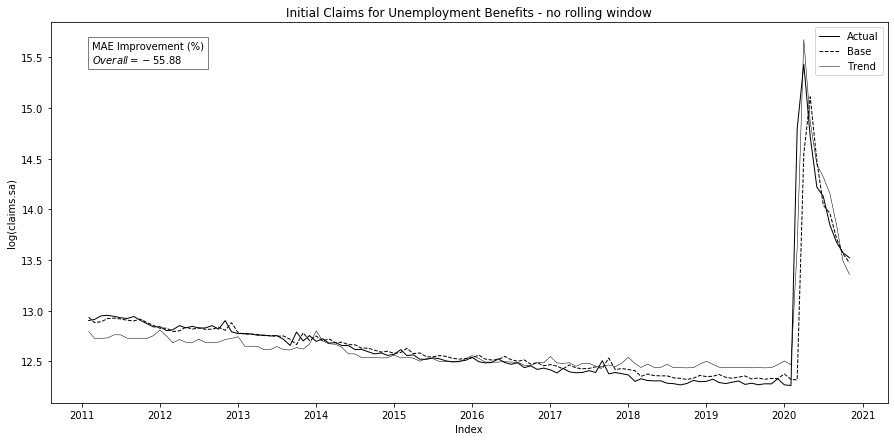

In [16]:
#Plots :
fig,ax = plt.subplots()
ax.plot(iclaims['DATE'][1:],iclaims['ICSA'][1:],color='black',label='Actual',linewidth=1)
ax.plot(iclaims['DATE'][1:],Predictions,linestyle='--',color='black',label='Base',linewidth=1)
ax.plot(iclaims['DATE'][1:],Predictions_trends,color='black',linewidth=0.5,label='Trend')
plt.legend()
textstr = '\n'.join((
    r'MAE Improvement (%)',
    r'$Overall=%.2f$'%(improvement_overall,)))
    
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top',bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel('log(claims.sa)')
ax.set_xlabel('Index')
ax.set_title('Initial Claims for Unemployment Benefits - no rolling window')
fig.set_size_inches(15,7)
plt.show()

## Q3 : Has Google Trends the power to help us predict one-month-ahead movements of the USD/EUR rate ?

## Data Management :

We have 5 data_sets, $4$ of them are the Google Trends for words related to the price level in US and 3 major European countries/regions (Great Britain, Germany, France). We will try to estimate if the variation of the price related trends between US and Europe can give us a good estimation of the USD/EUR rate movements.

### Cleaning our Datasets

In [17]:
# Load The datasets
ExRate = pd.read_csv('EXUSEU.csv')
TrendsUS = pd.read_csv('TrendsPrice_US.csv')
TrendsGB = pd.read_csv('TrendsPrice_GB.csv')
TrendsGR = pd.read_csv('TrendsPrice_Germany.csv')
TrendsFR = pd.read_csv('TrendsPrice_France.csv')

# Reshaping Each DataFrame
## US
TrendsUS = TrendsUS.reset_index()
TrendsUS.rename(columns = {'level_0':'Month'}, inplace = True)
TrendsUS.rename(columns = {'level_1':'Inflation'}, inplace = True)
TrendsUS.rename(columns = {'level_2':'Prices'}, inplace = True)
TrendsUS.rename(columns = {'level_3':'CPI'}, inplace = True)
TrendsUS.rename(columns = {'Catégorie\xa0: Toutes catégories':'Cheap'}, inplace = True)
TrendsUS = TrendsUS.drop([0])
TrendsUS = TrendsUS.reset_index().drop('index',axis=1)
## GB
TrendsGB = TrendsGB.reset_index()
TrendsGB.rename(columns = {'level_0':'Month'}, inplace = True)
TrendsGB.rename(columns = {'level_1':'Inflation'}, inplace = True)
TrendsGB.rename(columns = {'level_2':'Prices'}, inplace = True)
TrendsGB.rename(columns = {'level_3':'CPI'}, inplace = True)
TrendsGB.rename(columns = {'Catégorie\xa0: Toutes catégories':'Cheap'}, inplace = True)
TrendsGB = TrendsGB.drop([0])
TrendsGB = TrendsGB.reset_index().drop('index',axis=1)
## Germany
TrendsGR = TrendsGR.reset_index()
TrendsGR.rename(columns = {'level_0':'Month'}, inplace = True)
TrendsGR.rename(columns = {'level_1':'Inflation'}, inplace = True)
TrendsGR.rename(columns = {'level_2':'Prices'}, inplace = True)
TrendsGR.rename(columns = {'level_3':'CPI'}, inplace = True)
TrendsGR.rename(columns = {'Catégorie\xa0: Toutes catégories':'Cheap'}, inplace = True)
TrendsGR = TrendsGR.drop([0])
TrendsGR = TrendsGR.reset_index().drop('index',axis=1)
## France
TrendsFR = TrendsFR.reset_index()
TrendsFR.rename(columns = {'level_0':'Month'}, inplace = True)
TrendsFR.rename(columns = {'level_1':'Inflation'}, inplace = True)
TrendsFR.rename(columns = {'level_2':'Prices'}, inplace = True)
TrendsFR.rename(columns = {'level_3':'CPI'}, inplace = True)
TrendsFR.rename(columns = {'Catégorie\xa0: Toutes catégories':'Cheap'}, inplace = True)
TrendsFR = TrendsFR.drop([0])
TrendsFR = TrendsFR.reset_index().drop('index',axis=1)
print(TrendsFR.head())
print(' ')
print(' ')

# We replace <1 values by 0 and make sure that all our values are float for each DataFrame :
## US
TrendsUS['Inflation']= [float(s.replace('<\xa01','0')) for s in TrendsUS['Inflation']]
TrendsUS['Prices']= [float(s.replace('<\xa01','0')) for s in TrendsUS['Prices']]
TrendsUS['CPI']= [float(s.replace('<\xa01','0')) for s in TrendsUS['CPI']]
TrendsUS['Cheap']= [float(s.replace('<\xa01','0')) for s in TrendsUS['Cheap']]
## GB
TrendsGB['Inflation']= [float(s.replace('<\xa01','0')) for s in TrendsGB['Inflation']]
TrendsGB['Prices']= [float(s.replace('<\xa01','0')) for s in TrendsGB['Prices']]
TrendsGB['CPI']= [float(s.replace('<\xa01','0')) for s in TrendsGB['CPI']]
TrendsGB['Cheap']= [float(s.replace('<\xa01','0')) for s in TrendsGB['Cheap']]
## GR
TrendsGR['Inflation']= [float(s.replace('<\xa01','0')) for s in TrendsGR['Inflation']]
TrendsGR['Prices']= [float(s.replace('<\xa01','0')) for s in TrendsGR['Prices']]
TrendsGR['CPI']= [float(s.replace('<\xa01','0')) for s in TrendsGR['CPI']]
TrendsGR['Cheap']= [float(s.replace('<\xa01','0')) for s in TrendsGR['Cheap']]
## FR
TrendsFR['Inflation']= [float(s.replace('<\xa01','0')) for s in TrendsFR['Inflation']]
TrendsFR['Prices']= [float(s.replace('<\xa01','0')) for s in TrendsFR['Prices']]
TrendsFR['CPI']= [float(s.replace('<\xa01','0')) for s in TrendsFR['CPI']]
TrendsFR['Cheap']= [float(s.replace('<\xa01','0')) for s in TrendsFR['Cheap']]
print(TrendsFR.head())
print(' ')
print(' ')

### so far j'ai pas trouvé de moyen pour automatiser/optimiser ca...

     Month Inflation Prices  CPI Cheap
0  2004-01         1     47    1    11
1  2004-02         1     46    1    13
2  2004-03         1     47  < 1    11
3  2004-04         1     48    1    13
4  2004-05       < 1     52  < 1    14
 
 
     Month  Inflation  Prices  CPI  Cheap
0  2004-01        1.0    47.0  1.0   11.0
1  2004-02        1.0    46.0  1.0   13.0
2  2004-03        1.0    47.0  0.0   11.0
3  2004-04        1.0    48.0  1.0   13.0
4  2004-05        0.0    52.0  0.0   14.0
 
 


### Creating a unique European Trends Dataset

To do so, we consider that a good European trend estimator is the average of the 3 countries trends. 

In [18]:
## Now that our DataFrames are all clean and ready for use we average the values of each trends to one European trend
InflationUE =[]
PricesUE =[]
CPIUE=[]
CheapUE=[]

for i in range(len(TrendsGB)):
    InflationUE.append(statistics.mean([TrendsGR['Inflation'][i],TrendsGB['Inflation'][i],TrendsFR['Inflation'][i]]))
    PricesUE.append(statistics.mean([TrendsGR['Prices'][i],TrendsGB['Prices'][i],TrendsFR['Prices'][i]]))
    CPIUE.append(statistics.mean([TrendsGR['CPI'][i],TrendsGB['CPI'][i],TrendsFR['CPI'][i]]))
    CheapUE.append(statistics.mean([TrendsGR['Cheap'][i],TrendsGB['Cheap'][i],TrendsFR['Cheap'][i]]))

TrendsUE = pd.DataFrame({'Month':TrendsUS['Month'],'Inflation':InflationUE,'Prices':PricesUE,'CPI':CPIUE,'Cheap':CheapUE})

print('Trends_UE DataFrame :')
print(TrendsUE.head())
print(' ')
print(' ')
print('Trends_US DataFrame :')
print(TrendsUS.head())
print(' ')
print(' ')
print('Exchange Rate US-UE DataFrame :')
print(ExRate.head())
print(' ')
print(' ')

Trends_UE DataFrame :
     Month  Inflation     Prices       CPI      Cheap
0  2004-01   1.666667  43.000000  0.666667  57.333333
1  2004-02   1.333333  42.666667  0.666667  54.000000
2  2004-03   1.333333  42.000000  0.333333  51.666667
3  2004-04   1.333333  42.333333  0.666667  56.000000
4  2004-05   1.000000  43.666667  0.333333  58.333333
 
 
Trends_US DataFrame :
     Month  Inflation  Prices  CPI  Cheap
0  2004-01        3.0    42.0  2.0   89.0
1  2004-02        3.0    42.0  1.0   86.0
2  2004-03        3.0    45.0  1.0   84.0
3  2004-04        3.0    46.0  1.0   83.0
4  2004-05        3.0    53.0  1.0   90.0
 
 
Exchange Rate US-UE DataFrame :
         DATE  EXUSEU
0  1999-01-01  1.1591
1  1999-02-01  1.1203
2  1999-03-01  1.0886
3  1999-04-01  1.0701
4  1999-05-01  1.0630
 
 


### Creating the Merged Dataset

We will evaluate the USD/EUR rate using as variables : a seasonnal term of 1 month before and the difference between US and Europe for each price related trends.

In [19]:
idx = ExRate.loc[ExRate['DATE'].isin(['2004-01-01'])].index.tolist()[0] 
ExRate_clean = ExRate[idx:].reset_index()
ExRate_clean['s1']=ExRate_clean['EXUSEU'].shift(1,axis=0,fill_value=0) # create seasonnal term for sa claims

data_rate = pd.DataFrame({'Month':TrendsUE['Month'][:len(TrendsUS)-1],
                          'EXUSEU':ExRate_clean['EXUSEU'],
                          'D_Inflation':(TrendsUS['Inflation'][:len(TrendsUS)-1]-TrendsUE['Inflation'][:len(TrendsUS)-1]),
                          'D_Prices':(TrendsUS['Prices'][:len(TrendsUS)-1]-TrendsUE['Prices'][:len(TrendsUS)-1]),
                          'D_CPI':(TrendsUS['CPI'][:len(TrendsUS)-1]-TrendsUE['CPI'][:len(TrendsUS)-1]),
                          'D_Cheap':(TrendsUS['Cheap'][:len(TrendsUS)-1]-TrendsUE['Cheap'][:len(TrendsUS)-1]),
                          's1':ExRate_clean['s1']
                         })

data_rate.Month = pd.to_datetime(data_rate.Month)
data_rate = data_rate.set_index(data_rate['Month'])
data_rate.index = pd.DatetimeIndex(data_rate.index.values,freq='MS') # Indicate that our index is sampled by weeks
data_rate.head()

,Month,EXUSEU,D_Inflation,D_Prices,D_CPI,D_Cheap,s1
2004-01-01,2004-01-01,1.2638,1.333333,-1.000000,1.333333,31.666667,0.0000
2004-02-01,2004-02-01,1.2640,1.666667,-0.666667,0.333333,32.000000,1.2638
2004-03-01,2004-03-01,1.2261,1.666667,3.000000,0.666667,32.333333,1.2640
2004-04-01,2004-04-01,1.1989,1.666667,3.666667,0.333333,27.000000,1.2261
2004-05-01,2004-05-01,1.2000,2.000000,9.333333,0.666667,31.666667,1.1989


### Baseline model :

We only use a seasonnal term $y_{t-1}$ for the linear regression.

In [20]:
mod = smf.ols(formula = 'EXUSEU ~ s1', data= data_rate )
res = mod.fit()
Predictions = res.predict()

### Trends model :

We use the seasonnal term $y_{t-1}$ and the variation of the Google Trends related to price between US and UE.

In [21]:
# Trends Model :
mod_trends = smf.ols(formula = 'EXUSEU ~ s1 + D_Inflation + D_Prices + D_CPI + D_Cheap ', data=data_rate )
res_trends = mod_trends.fit()
Predictions_trends = res_trends.predict()

### MAEs :

We evaluate the overall MAEs, as we don't know the turning points. Finding turning points will be one goal of the figure analysis.

In [22]:
mae_base_overall = mean_absolute_error(data_rate.EXUSEU,Predictions)/(data_rate.EXUSEU.mean())
mae_trends_overall = mean_absolute_error(data_rate.EXUSEU,Predictions_trends)/(data_rate.EXUSEU.mean())
improvement_overall = (mae_base_overall-mae_trends_overall)/mae_base_overall*100

In [23]:
print('MAE Trends Overall =',mae_trends_overall)
print('MAE Base Overall =',mae_base_overall)

MAE Trends Overall = 0.03502166467035493
MAE Base Overall = 0.03602069000803789


### Plots :

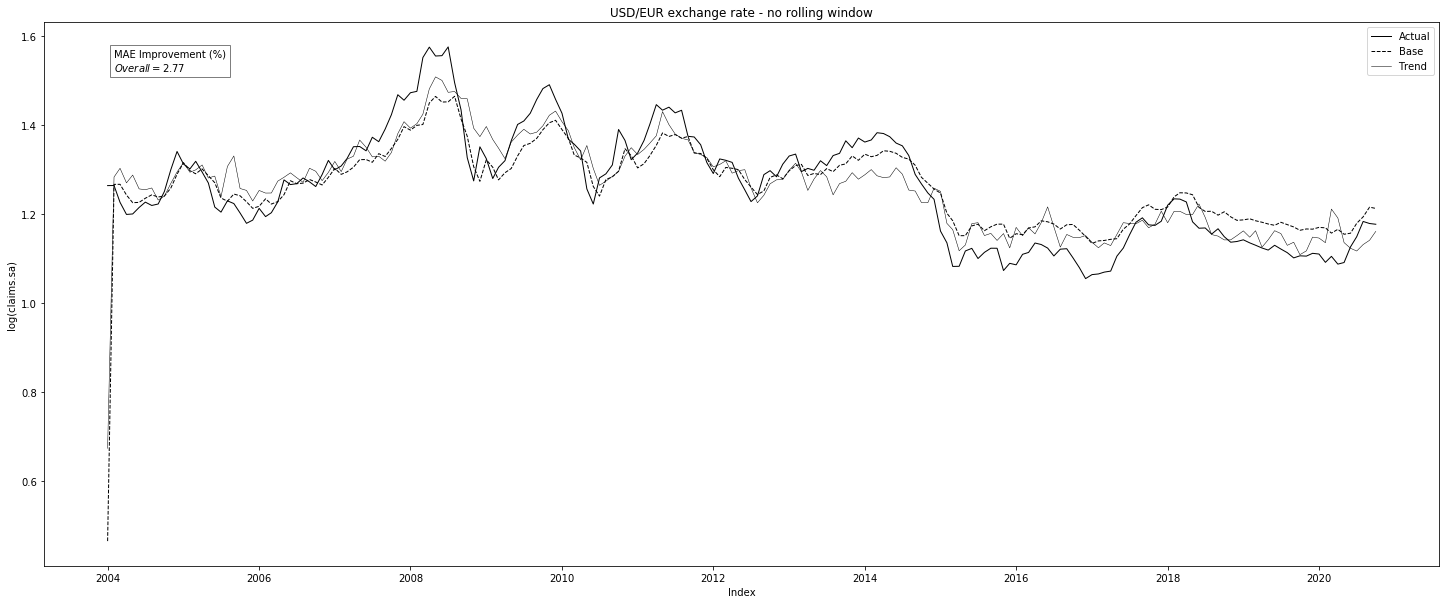

In [25]:
#Plots :
fig,ax = plt.subplots()
ax.plot(data_rate['Month'],data_rate['EXUSEU'],color='black',label='Actual',linewidth=1)
ax.plot(data_rate['Month'],Predictions,linestyle='--',color='black',label='Base',linewidth=1)
ax.plot(data_rate['Month'],Predictions_trends,color='black',linewidth=0.5,label='Trend')
plt.legend()
textstr = '\n'.join((
    r'MAE Improvement (%)',
    r'$Overall=%.2f$'%(improvement_overall,)))
    
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top',bbox=dict(facecolor='white', alpha=0.5))
ax.set_ylabel('log(claims.sa)')
ax.set_xlabel('Index')
ax.set_title('USD/EUR exchange rate - no rolling window')
fig.set_size_inches(25,10)
plt.show()